In [1]:
import numpy as np
import matplotlib.pyplot as pl
import time as tt

# 1D Case


## Mean Field (acctually)

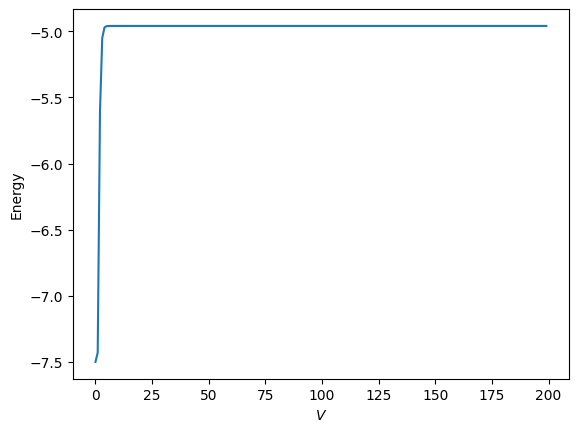

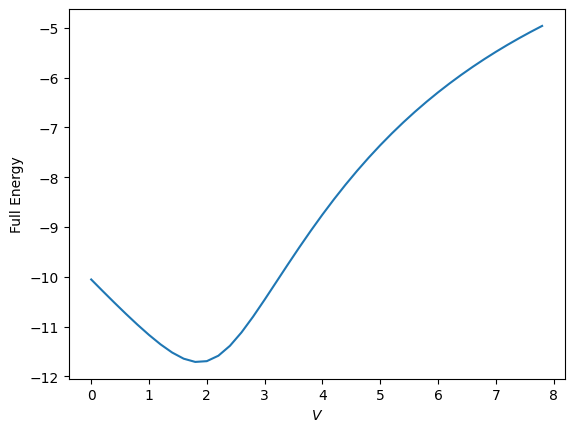

In [ ]:

def hamil(V,n):
    H = np.zeros((L,L))
    for i in range(L):
        H[i,i] = -V/2*(n[np.mod(i+1,L)] + n[np.mod(i-1,L)])
        H[i,np.mod(i+1,L)] = -1
        H[np.mod(i+1,L),i] = -1
    return(H)


def mf(V,n,L):
    energy_list = []
    for i in range(200):
        H = hamil(V,n)
        E,U = np.linalg.eigh(H)
        C = np.dot(U[:,:L//2],np.conj(U[:,:L//2].T))
        n = np.diag(C)
        energy_list.append(fullEnergy(C))
    return n, C, energy_list


def fullEnergy(C):
    E=0
    for j in range(L):
        E += -(C[j,np.mod(j+1,L)] + C[np.mod(j+1,L),j])
        E += -V/2*(C[j,j]*C[np.mod(j+1,L),np.mod(j+1,L)] - C[j,np.mod(j+1,L)]*C[np.mod(j+1,L),j])

    return E

L = 16
n = [1.,0.]*(L//2)
n += np.random.randn(L)
Vs = np.arange(0,8,0.2)

ns = []
energy = []
for V in Vs:
    density, C, energy_list = mf(V,n,L)
    ns.append( sum(density[:]) )
    energy.append(fullEnergy(C))
    # print(V)
    # pl.plot(energy_list)
    # pl.show()



pl.plot(energy_list)
pl.ylabel("Energy")
pl.xlabel("$V$")
pl.show()

pl.plot(Vs, energy)
pl.ylabel("Full Energy")
pl.xlabel("$V$")
pl.show()

# ns = np.array(ns).T

# pl.plot(Vs,ns,".")
# # pl.plot(Vs,ns[0,:],".")
# # pl.plot(Vs,ns[1,:],".")
# pl.ylabel("$n$")
# pl.xlabel("$V$")
# pl.show()



## Hartree Fock (real)

### normal Hartree Fock

In [2]:

def FF_hamil(physical, L, **kwargs):
    PBC = kwargs['PBC'] if 'PBC' in kwargs.keys() else True

    V, J = physical[:2]
    
    H = np.zeros((L,L))
    for i in range(L-int(not PBC)):
        # H[i,i] = +V/2*(cmat[np.mod(i+1,L),np.mod(i+1,L)] + cmat[np.mod(i-1,L),np.mod(i-1,L)])
        H[i,np.mod(i+1,L)] = -J 
        H[np.mod(i+1,L),i] = -J
    
    return(H)


def MF_hamil(physical, cmat, L, **kwargs):
    PBC = kwargs['PBC'] if 'PBC' in kwargs.keys() else True

    V, J = physical[:2]
    
    H = np.zeros((L,L))
    for i in range(L-int(not PBC)):
        H[i,i] = +V/2*(cmat[np.mod(i+1,L),np.mod(i+1,L)] + cmat[np.mod(i-1,L),np.mod(i-1,L)])
        H[i,np.mod(i+1,L)] = -J 
        H[np.mod(i+1,L),i] = -J
    
    return(H)


def HF_hamil(physical, cmat, L, **kwargs):
    PBC = kwargs['PBC'] if 'PBC' in kwargs.keys() else True
    
    V, J = physical[:2]
    
    H = np.zeros((L,L))
    
    if PBC==True:
    
        for i in range(L):
            H[i,i] = +V/2*(cmat[np.mod(i+1,L),np.mod(i+1,L)] + cmat[np.mod(i-1,L),np.mod(i-1,L)])
            H[i,np.mod(i+1,L)] = -J - V/2*cmat[np.mod(i+1,L),i]
            H[np.mod(i+1,L),i] = -J - V/2*cmat[i,np.mod(i+1,L)]
    
    if PBC == False:

        for i in range(L-1):
            H[i,np.mod(i+1,L)] = -J - V/2*cmat[np.mod(i+1,L),i]
            H[np.mod(i+1,L),i] = -J - V/2*cmat[i,np.mod(i+1,L)]
        
        for i in range(1, L-1):
            H[i,i] = +V/2*(cmat[np.mod(i+1,L),np.mod(i+1,L)] + cmat[np.mod(i-1,L),np.mod(i-1,L)])
        
        H[0,0] = +V/2*cmat[1,1] 
        H[L-1,L-1] = +V/2*cmat[L-2,L-2]
    
    return(H)


def fullEnergy_HF(input_C, physical, L, **kwargs):
    PBC = kwargs['PBC'] if 'PBC' in kwargs.keys() else True
    
    V, J = physical[:2]
    E=0
    for j in range(L-int(not PBC)):
        E += - J*(input_C[j,np.mod(j+1,L)] + input_C[np.mod(j+1,L),j])
        E += + V/2*(input_C[j,j]*input_C[np.mod(j+1,L),np.mod(j+1,L)] - input_C[j,np.mod(j+1,L)]*input_C[np.mod(j+1,L),j])

    return(E)


def mean_field_optimization(physical,L, **kws):
    max_iters = kws['max_iters'] if 'max_iters' in kws.keys() else 400
    startp = kws['start_point'] if 'start_point' in kws.keys() else 0.15
    
    c_mat = np.diag([1.,0.]*(L//2) + startp * np.random.randn(L))
    
    last_E = np.empty((L))
    output_energy = 0.0
    for _ in range(max_iters):
        H = MF_hamil(physical, c_mat, L)
        last_E, U = np.linalg.eigh(H)
        c_mat = np.dot(U[:,:L//2],np.conj(U[:,:L//2].T))
        # output_energy = fullEnergy_HF(c_mat, physical, L, **kws)
    
    return(last_E, np.diag(c_mat))


def hart_fock_optimization(physical,L, **kws):
    max_iters = kws['max_iters'] if 'max_iters' in kws.keys() else 100
    startp = kws['start_point'] if 'start_point' in kws.keys() else 0.0004567
    
    c_mat = np.diag([1.,0.]*(L//2) + startp * np.random.randn(L))
    
    last_E = np.empty((L))
    output_energy = 0.0
    energy=[]
    for _ in range(max_iters):
        H = HF_hamil(physical, c_mat, L, **kws)
        last_E, U = np.linalg.eigh(H)
        c_mat = np.dot(U[:,:L//2],np.conj(U[:,:L//2].T))
        output_energy = fullEnergy_HF(c_mat, physical, L, **kws)
        energy.append(output_energy)
    return(energy)#(last_E, np.diag(c_mat))


[0.11, 0.55, 0.99, 1.76, 3.13, 8.27]


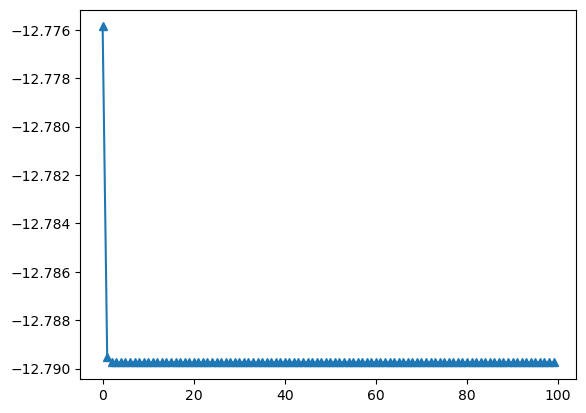

In [4]:
L = 20
num_plts = 8
V_list =  [0.11, 0.55, 0.99, 1.76, 3.13, 8.27] #np.linspace(0.01, 3.3, num=num_plts, dtype=np.float16)
print( V_list )

# fig, ax = pl.subplots(1,2, figsize=(18, 6) )

HF_data = []
MF_data = []
FF_data = []
hf_energy = hart_fock_optimization([-.11,1.0], L)
# mf_energy, mf_part = mean_field_optimization([-.11,1.0], L)
# for plt, Vs in enumerate(V_list):
#     hf_uniq = np.unique( np.round(hf_energy, decimals=7), return_index=False)
#     HF_data.append(hf_energy)
#     # print(hf_energy)
#     MF_data.append(mf_energy)
#     # print(mf_energy)
#     ax[0].plot(hf_part, label=f'HF V={Vs:.2f}', color=f'C{plt}', linestyle='-')
#     ax[0].plot(mf_part, label=f'MF V={Vs:.2f}', color=f'C{plt}', linestyle='--')
#     print("---")

# ax[0].set_title(r"$\langle n_i \rangle$ for different V's (HF vs MF) for L=10 (repulsive)")
# ax[0].set_xlabel(r"$i^{th}$ site", rotation='horizontal', fontsize='large')    
# ax[0].set_ylabel(r"$\langle n_i \rangle $", fontsize='large')    
# ax[0].legend(ncols=2)

# ax[1].plot(V_list, HF_data, label=f'HF', color='C0', linestyle='-', marker='^')
# ax[1].plot(V_list, MF_data, label=f'HF', color='C1', linestyle='-', marker='v')
# ax[1].set_title(r"$\langle H \rangle$ for different V's (HF vs MF) for L=10 (repulsive)")
# ax[1].set_xlabel(r"V", rotation='horizontal', fontsize='large')    
# ax[1].set_ylabel(r"$\langle H \rangle$", fontsize='large')    
# ax[1].legend()
# fig.savefig("Super_Amp_L10_(attractive)_(FF).pdf", bbox_inches = 'tight')


# for plt, Vs in enumerate(V_list):
#     hf_energy, hf_part = hart_fock_optimization([Vs,1.0], L)
#     hf_uniq = np.unique( np.round(hf_energy, decimals=7), return_index=False)
#     HF_data.append(len(hf_uniq))
#     # print(hf_energy)
    
#     mf_energy, mf_part = mean_field_optimization([Vs,1.0], L)
#     mf_uniq = np.unique( np.round(mf_energy, decimals=7), return_index=False)
#     MF_data.append(len(mf_uniq))
#     # print(mf_energy)
    
#     H = FF_hamil((Vs, 1.0), L)
#     ff_E, UU = np.linalg.eigh(H)
#     ff_uniq = np.unique( np.round(ff_E, decimals=7), return_index=False)
#     FF_data.append(len(ff_uniq))
#     print("---")
   
pl.plot(hf_energy, label=f'HF', color='C0', linestyle='-', marker='^')
# pl.plot(V_list, MF_data, label=f'MF', color='C1', linestyle='-', marker='v')
# pl.plot(V_list, FF_data, label=f'FF', color='C2', linestyle='-', marker='.')
# pl.title(r"independet fermion energy modes for different V's for L=10")
# pl.xlabel(f"v", fontsize='large')    
# pl.ylabel(r"$N_{independent}/N_{total}$", fontsize='large')    
# pl.legend()
# # pl.savefig("Degeneracy_L12_(HF,MF,FF).jpg", bbox_inches = 'tight')

pl.show()

# for a in range(1,4):
#     print(a+1)      

### Superposition energy Hartree-Fock

In [13]:


def energy_func(n, mode_energis):
    L = len(mode_energis)
    K_list = np.array([int(i) for i in np.binary_repr(n, width=L)])
    if len(K_list) != L:
        print("Error - -")
        return( ) 
    return( np.array(K_list) @ np.array(mode_energis) )


def basis_set(L):
    N = L//2
    basis_N = []
    for n in range(2**L):
        bin_state = np.array([int(i) for i in np.binary_repr(n, width=L)])
        if sum(bin_state) == N:
            basis_N.append(n)
    return basis_N


def C_term(U_mat, kk, qq, L, **kwargs):
    PBC = kwargs['PBC'] if 'PBC' in kwargs.keys() else True
    
    nn = kk ^ qq
    if nn == 0:
        indxs = np.nonzero([int(i) for i in np.binary_repr(kk, width=L)])[0]
        out_mat = np.dot(U_mat[:,indxs], np.conj(U_mat[:,indxs].T))
        out_val = np.trace(out_mat, offset=1) + np.trace(out_mat, offset=-1) + int(PBC)*np.trace(out_mat, offset=L-1) + int(PBC)*np.trace(out_mat, offset=-L+1)
        return out_val 
    else:        
        k_set = np.nonzero([int(i) for i in np.binary_repr(kk, width=L)])[0]
        q_set = np.nonzero([int(i) for i in np.binary_repr(qq, width=L)])[0]
        k,q = np.setdiff1d(k_set,q_set), np.setdiff1d(q_set,k_set)
            
        if len(k)==len(q) and len(q)==1:
            sign_k = k_set[k_set>k].size
            sign_q = q_set[q_set>q].size
            out_sign = ((-1)**(sign_k))*((-1)**(sign_q))
            
            # out_val = 0.0 #same as the next, but with aloop and slower 
            # for el in range(L-int(not PBC)):
            #     out_val += U_mat[np.mod(el  ,L),k] * np.conj(U_mat[np.mod(el+1,L),q])
            #     out_val += U_mat[np.mod(el+1,L),k] * np.conj(U_mat[np.mod(el  ,L),q])
                
            out_mat = np.dot(U_mat[:,k], np.conj(U_mat[:,q]).T)
            out_val = np.trace(out_mat, offset=1) + np.trace(out_mat, offset=-1) + int(PBC)*np.trace(out_mat, offset=L-1) + int(PBC)*np.trace(out_mat, offset=-L+1)
            
            return out_sign * out_val
        
        return 0.0
        

## determinant method
def C_test(U_mat,kk,qq, L, **kwargs):
    PBC = kwargs['PBC'] if 'PBC' in kwargs.keys() else True
    nn = kk ^ qq
    if nn == 0:
        indxs = np.nonzero([int(i) for i in np.binary_repr(kk, width=L)])[0]
        out_mat = np.dot(U_mat[:,indxs], np.conj(U_mat[:,indxs].T))
        out_val = np.trace(out_mat, offset=1) + np.trace(out_mat, offset=-1) + int(PBC)*np.trace(out_mat, offset=L-1) + int(PBC)*np.trace(out_mat, offset=-L+1)
        return out_val 
    else:        
        k_set = np.nonzero([int(i) for i in np.binary_repr(kk, width=L)])[0]
        q_set = np.nonzero([int(i) for i in np.binary_repr(qq, width=L)])[0]
        k,q = np.setdiff1d(k_set,q_set), np.setdiff1d(q_set,k_set)
        
        if len(k)==len(q) and len(q)==1:
            left = U_mat[:,k_set]
            right = U_mat[:,q_set].T
            term = 0.0
            for j in range(L-int(not PBC)):
                Z1 = np.array( [0]*j + [1] + [0]*(L-j-1) ).reshape((1,L))
                Z2 = np.array( [0]*np.mod(j+1,L) + [1] + [0]*(L-np.mod(j+1,L)-1) ).reshape((1,L))
        
                L1 = np.concatenate((left, Z1.T ), axis=1)
                R1 = np.concatenate((right, Z2 ), axis=0)
                term += np.linalg.det( np.dot(R1,L1) )
                
                L2 = np.concatenate((left, Z2.T ), axis=1)
                R2 = np.concatenate((right, Z1 ), axis=0)
                term += np.linalg.det( np.dot(R2,L2) )
            return -1*term        
        
        return 0.0
        


def V_term(U_mat, kk, qq, L, **kwargs):
    PBC = kwargs['PBC'] if 'PBC' in kwargs.keys() else True

    nn = kk ^ qq
    if nn == 0:
        indxs = np.nonzero([int(i) for i in np.binary_repr(kk, width=L)])[0]
        out_mat = np.dot(U_mat[:,indxs], np.conj(U_mat[:,indxs].T))
        out_val = 0.0
        for j in range(L-int(not PBC)):
            out_val += out_mat[j,j]*out_mat[np.mod(j+1,L),np.mod(j+1,L)] - out_mat[j,np.mod(j+1,L)]*out_mat[np.mod(j+1,L),j]
            
        return out_val 
    
    else:        
        k_set = np.nonzero([int(i) for i in np.binary_repr(kk, width=L)])[0]
        q_set = np.nonzero([int(i) for i in np.binary_repr(qq, width=L)])[0]
        dif_k,dif_q = np.setdiff1d(k_set,q_set), np.setdiff1d(q_set,k_set)
                
        if len(dif_k) == len(dif_q) and len(dif_k) == 1:
            equl = np.intersect1d(k_set,q_set)
            inner_c = np.dot(U_mat[:,equl], np.conj(U_mat[:,equl]).T)
            
            sign_k = k_set[k_set > dif_k].size
            sign_q = q_set[q_set > dif_q].size
            out_sign = ((-1)**(sign_k))*((-1)**(sign_q))
            
            out_val = 0.0
            for j in range(L-int(not PBC)):
                out_val += -1*( U_mat[np.mod(j+1,L),dif_k] * inner_c[np.mod(j  ,L),np.mod(j+1,L)] * np.conj(U_mat[np.mod(j  ,L),dif_q]) )
                out_val += -1*( U_mat[np.mod(j  ,L),dif_k] * inner_c[np.mod(j+1,L),np.mod(j  ,L)] * np.conj(U_mat[np.mod(j+1,L),dif_q]) )
                out_val += +1*( U_mat[np.mod(j  ,L),dif_k] * inner_c[np.mod(j+1,L),np.mod(j+1,L)] * np.conj(U_mat[np.mod(j  ,L),dif_q]) )
                out_val += +1*( U_mat[np.mod(j+1,L),dif_k] * inner_c[np.mod(j  ,L),np.mod(j  ,L)] * np.conj(U_mat[np.mod(j+1,L),dif_q]) )            
        
            return out_sign * out_val[0]
        
        if len(dif_k) == len(dif_q) and len(dif_k) == 2:
            sign_k = k_set[k_set > dif_k[0]]
            sign_k = sign_k[sign_k < dif_k[1]].size
            
            sign_q = q_set[q_set > dif_q[0]]
            sign_q = sign_q[sign_q < dif_q[1]].size
            
            out_sign = ((-1)**(sign_k))*((-1)**(sign_q))
            
            out_val = 0.0
            for j in range(L-int(not PBC)):
                out_val += +1*( U_mat[np.mod(j,L),dif_k[0]] * U_mat[np.mod(j+1,L),dif_k[1]] * np.conj(U_mat[np.mod(j ,L),dif_q[0]]) * np.conj(U_mat[np.mod(j+1,L),dif_q[1]]) )
                out_val += -1*( U_mat[np.mod(j,L),dif_k[0]] * U_mat[np.mod(j+1,L),dif_k[1]] * np.conj(U_mat[np.mod(j ,L),dif_q[1]]) * np.conj(U_mat[np.mod(j+1,L),dif_q[0]]) )
                out_val += -1*( U_mat[np.mod(j,L),dif_k[1]] * U_mat[np.mod(j+1,L),dif_k[0]] * np.conj(U_mat[np.mod(j ,L),dif_q[0]]) * np.conj(U_mat[np.mod(j+1,L),dif_q[1]]) )
                out_val += +1*( U_mat[np.mod(j,L),dif_k[1]] * U_mat[np.mod(j+1,L),dif_k[0]] * np.conj(U_mat[np.mod(j ,L),dif_q[1]]) * np.conj(U_mat[np.mod(j+1,L),dif_q[0]]) )
                
            return out_sign * out_val
        
        return 0.0
        

        
## determinant method
def V_test(U_mat, kk, qq, L, **kwargs):
    PBC = kwargs['PBC'] if 'PBC' in kwargs.keys() else True

    nn = kk ^ qq    

    if nn == 0:
        indxs = np.nonzero([int(i) for i in np.binary_repr(kk, width=L)])[0]
        out_mat = np.dot(U_mat[:,indxs], np.conj(U_mat[:,indxs].T))
        out_val = 0.0
        for j in range(L-int(not PBC)):
            out_val += out_mat[j,j]*out_mat[np.mod(j+1,L),np.mod(j+1,L)] - out_mat[j,np.mod(j+1,L)]*out_mat[np.mod(j+1,L),j]
        return out_val

    else:
        k_set = np.nonzero([int(i) for i in np.binary_repr(kk, width=L)])[0]
        q_set = np.nonzero([int(i) for i in np.binary_repr(qq, width=L)])[0]
        dL,dR = np.setdiff1d(k_set,q_set), np.setdiff1d(q_set,k_set)
        
        if len(dL)==len(dR) and len(dL) <= 2:
            left = U_mat[:,k_set]
            right = U_mat[:,q_set].T
            term = np.linalg.det( np.dot(right,left) )
            for j in range(L-int(not PBC)):
                Z1 = np.array( [0]*j + [1] + [0]*(L-j-1) ).reshape((1,L))
                Z2 = np.array( [0]*np.mod(j+1,L) + [1] + [0]*(L-np.mod(j+1,L)-1) ).reshape((1,L))
                
                L1 = np.concatenate((left, Z1.T ), axis=1)
                R1 = np.concatenate((right, Z1 ), axis=0)
                term += - np.linalg.det( np.dot(R1,L1) )
                
                L2 = np.concatenate((left, Z2.T ), axis=1)
                R2 = np.concatenate((right, Z2 ), axis=0)
                term += - np.linalg.det( np.dot(R2,L2) )
                
                L3 = np.concatenate((left, Z1.T, Z2.T ), axis=1)
                R3 = np.concatenate((right, Z1, Z2 ), axis=0)
                term += + np.linalg.det( np.dot(R3,L3) )
                        
            return term     
        else:
            return 0.0



def ordered_basis(L, mode_energis, **kwargs):
    basis_len = kwargs['basis_len'] if 'basis_len' in kwargs.keys() else None
    
    N = L//2
    basis_N = []
    order_set = []
    for n in range(2**L):
        bin_state = np.array([int(i) for i in np.binary_repr(n, width=L)])
        if sum(bin_state) == N:
            basis_N.append(n)
            order_set.append( np.array(bin_state) @ np.array(mode_energis) )
    order = np.argsort(order_set) 
    output = np.array(basis_N)[order.astype(int)]
    return(output[0:basis_len])
        

def ordered_basis_interaction(L, physical, **kwargs):
    basis_len = kwargs['basis_len'] if 'basis_len' in kwargs.keys() else None
    V, J = physical[:2]
    
    N = L//2
    basis_N = []
    order_set = []
    for n in range(2**L):
        bin_state = np.array([int(i) for i in np.binary_repr(n, width=L)])
        rolo_state = np.roll(bin_state, -1)
        if sum(bin_state) == N:
            basis_N.append(n)
            order_set.append( 0.5 * V * rolo_state @ bin_state  )
    order = np.argsort(order_set) 
    output = np.array(basis_N)[order.astype(int)]
    return(output[0:basis_len])
        

def basis_distance(basis_set,L, **kwargs):
    basis_len = kwargs['basis_len'] if 'basis_len' in kwargs.keys() else None
    
    distance_set = []
    for n in basis_set:
        n0 = basis_set[0]
        m = np.bitwise_and(n0, n)
        bin_state = np.array([int(i) for i in np.binary_repr(m, width=L)])
        distance = int(L/2 - np.sum(bin_state))
        distance_set.append(distance)
        
        print("")
        # print(n0," ,",n," ->",m," : ",bin_state)
        bin_0 = np.array([int(i) for i in np.binary_repr(n0, width=L)])
        bin = np.array([int(i) for i in np.binary_repr(n, width=L)])
        print(bin_0," : ",n0)
        print("                             ->",bin_state, " : ", m,"*********>",distance)
        print(bin," : ",n)
        # print("*************>>>",distance,"")
        print("")
    # order = np.argsort(order_set) 
    # output = np.array(basis_N)[order.astype(int)]
    return(distance_set)
        

def based_ham(physical, L, energy_list, u_mat, **kwargs):
    
    V, J = physical[:2]
    base_set = ordered_basis(L, energy_list, **kwargs)
    el = len(base_set)

    new_ham = np.zeros((el,el))    
    for indx_k, K in enumerate(base_set):
        for indx_q, Q in enumerate(base_set):
            new_ham[indx_k,indx_q] += 0.5*V*V_term(u_mat, K, Q, L, **kwargs)
            new_ham[indx_k,indx_q] += -J*C_term(u_mat, K, Q, L, **kwargs)
            
    return(new_ham)        
        

def hart_fock_superposition(physical,L, **kws):
    max_iters = kws['max_iters'] if 'max_iters' in kws.keys() else 200
    startp = kws['start_point'] if 'start_point' in kws.keys() else 0.15
    
    c_mat = np.diag([0.,0.]*(L//2) + startp * np.random.randn(L))
    
    last_E = np.empty((L))
    last_U = np.empty((L,L))
    # HF_energy = 0.0
    for _ in range(max_iters):
        H = HF_hamil(physical, c_mat, L, **kws)
        last_E, last_U = np.linalg.eigh(H)
        c_mat = np.dot(last_U[:,:L//2],np.conj(last_U[:,:L//2].T))
        # HF_energy = fullEnergy_HF(c_mat, physical, L)
    
    print("HF")
    new_ham = based_ham( physical, L, last_E, last_U, **kws)
    
    # return(HF_energy, new_E[0], new_U[:,0])
    return(new_ham)
        

def mean_field_superposition(physical, L, **kws):
    max_iters = kws['max_iters'] if 'max_iters' in kws.keys() else 200
    startp = kws['start_point'] if 'start_point' in kws.keys() else 0.25
    
    c_mat = np.diag([1.,0.]*(L//2) + startp * np.random.randn(L))
    
    last_E = np.empty((L))
    last_U = np.empty((L,L))
    # last_H = np.empty((L,L))
    MF_energy = 0.0
    for _ in range(max_iters):
        H = MF_hamil(physical, c_mat, L, **kws)
        last_E, last_U = np.linalg.eigh(H)
        # last_H = MF_hamil(physical, c_mat, L, **kws)
        # last_E, last_U = np.linalg.eigh(last_H)
        c_mat = np.dot(last_U[:,:L//2],np.conj(last_U[:,:L//2].T))
        MF_energy = fullEnergy_HF(c_mat, physical, L)
    
    print("MF")
    # print(last_E)
    new_ham = based_ham( physical, L, last_E, last_U, **kws)
    # print(np.diag(new_ham))
    # new_E, new_U = np.linalg.eigh(new_ham)
    
    # return(MF_energy, new_E[0], new_U[:,0])
    return(new_ham)
        

def free_fermion_superposition(physical,L, **kws):    
    # last_E = np.empty((L))
    # last_U = np.empty((L,L))

    H = FF_hamil(physical, L, **kws)
    last_E, last_U = np.linalg.eigh(H)
    c_mat = np.dot(last_U[:,:L//2],np.conj(last_U[:,:L//2].T))
    FF_energy = fullEnergy_HF(c_mat, physical, L)
    
    new_ham = based_ham( physical, L, last_E, last_U, **kws)
    # new_E, new_U = np.linalg.eigh(new_ham)
    
    return(new_ham)


In [16]:
L = 12
set0 = basis_set(L)
print(set0)
print("")
set1 = basis_distance(set0,L)
print(set1)
print("")

# physical = -.9731, 1.0 
# # hf_vwesion0 = free_fermion_superposition(physical, L)
# hf_vwesion0 = hart_fock_superposition(physical, L, max_iters=400, PBC=True)

# hf_new_E, hf_new_U = np.linalg.eigh(hf_vwesion0)
# print(len(hf_new_E))
# print(hf_new_E[:10])
# super_energy_hf = hf_new_E[0]
# print(super_energy_hf)
# print("")


# physical = -.9731, 1.0 
# # hf_vwesion1 = free_fermion_superposition(physical, L)
# hf_vwesion1 = hart_fock_superposition(physical, L, max_iters=400, PBC=False)
# hf_new_E, hf_new_U = np.linalg.eigh(hf_vwesion1)
# print(len(hf_new_E))
# print(hf_new_E[:10])
# super_energy_hf = hf_new_E[0]
# print(super_energy_hf)
# print("")

# mf_energy, super_energy1, vec = mean_field_superposition(physical, L, max_iters=400, basis_len = bs)
# print(super_energy1)
# print("")

# print(super_energy3)
# print("")
# from matplotlib.colors import LogNorm, SymLogNorm

# fig, ax = pl.subplots(1,2, figsize=(18, 18) )
# pl.plot(np.diag(hf_vwesion0), label="1st")
# pl.plot(np.diag(hf_vwesion1), label="2nd")
# fig, ax = pl.subplots()
# im0 = ax[0].imshow(hf_vwesion0, norm=SymLogNorm(linthresh=0.01, vmin=-v_fac, vmax=v_fac))
# ax[0].set_title(f'matrix elements for V=0.19 (HF)')
# im1 = ax[1].imshow(hf_vwesion1, norm=SymLogNorm(linthresh=0.01, vmin=-v_fac, vmax=v_fac))
# ax[1].set_title(f'matrix elements for V=6.11 (HF)')

# cb = fig.colorbar(im0, ax=ax, fraction=0.0215, pad=0.04)#orientation='vertical')
# cb.set_clim(-10,10)
# pl.legend()
# pl.show()

[63, 95, 111, 119, 123, 125, 126, 159, 175, 183, 187, 189, 190, 207, 215, 219, 221, 222, 231, 235, 237, 238, 243, 245, 246, 249, 250, 252, 287, 303, 311, 315, 317, 318, 335, 343, 347, 349, 350, 359, 363, 365, 366, 371, 373, 374, 377, 378, 380, 399, 407, 411, 413, 414, 423, 427, 429, 430, 435, 437, 438, 441, 442, 444, 455, 459, 461, 462, 467, 469, 470, 473, 474, 476, 483, 485, 486, 489, 490, 492, 497, 498, 500, 504, 543, 559, 567, 571, 573, 574, 591, 599, 603, 605, 606, 615, 619, 621, 622, 627, 629, 630, 633, 634, 636, 655, 663, 667, 669, 670, 679, 683, 685, 686, 691, 693, 694, 697, 698, 700, 711, 715, 717, 718, 723, 725, 726, 729, 730, 732, 739, 741, 742, 745, 746, 748, 753, 754, 756, 760, 783, 791, 795, 797, 798, 807, 811, 813, 814, 819, 821, 822, 825, 826, 828, 839, 843, 845, 846, 851, 853, 854, 857, 858, 860, 867, 869, 870, 873, 874, 876, 881, 882, 884, 888, 903, 907, 909, 910, 915, 917, 918, 921, 922, 924, 931, 933, 934, 937, 938, 940, 945, 946, 948, 952, 963, 965, 966, 969, 970, 9

In [34]:
## ploting all the apmlitudes ##


L = 10

physical = 0.19731, -1.0 
# hf_vwesion0 = free_fermion_superposition(physical, L)
hf_vwesion0 = hart_fock_superposition(physical, L, max_iters=400)
v_fac2 =  np.round(np.max([abs(np.max(hf_vwesion0)), abs(np.min(hf_vwesion0))]), decimals=8)
print(v_fac2)
print("")
print( np.max(abs(hf_vwesion0)[hf_vwesion0 > 1.e-12]) )
print( np.min(abs(hf_vwesion0)[hf_vwesion0 > 1.e-7]) )
print("")
physical = 0.19731, -1.0 
# hf_vwesion1 = free_fermion_superposition(physical, L)
hf_vwesion1 = hart_fock_superposition(physical, L, max_iters=400, PBC=False)
v_fac1 =  np.round(np.max([abs(np.max(hf_vwesion1)), abs(np.min(hf_vwesion1))]), decimals=8)
print(v_fac1)
v_fac = np.max([v_fac1,v_fac2])
# print(super_energy2)
# print("")

# mf_energy, super_energy1, vec = mean_field_superposition(physical, L, max_iters=400, basis_len = bs)
# print(super_energy1)
# print("")

# print(super_energy3)
# print("")
# from matplotlib.colors import LogNorm, SymLogNorm

# fig, ax = pl.subplots(1,2, figsize=(18, 18) )

# # fig, ax = pl.subplots()
# im0 = ax[0].imshow(hf_vwesion0, norm=SymLogNorm(linthresh=0.01, vmin=-v_fac, vmax=v_fac))
# ax[0].set_title(f'matrix elements for V=0.19 (HF)')
# im1 = ax[1].imshow(hf_vwesion1, norm=SymLogNorm(linthresh=0.01, vmin=-v_fac, vmax=v_fac))
# ax[1].set_title(f'matrix elements for V=6.11 (HF)')

# cb = fig.colorbar(im0, ax=ax, fraction=0.0215, pad=0.04)#orientation='vertical')
# # cb.set_clim(-10,10)
# pl.show()

HF
6.6154606

6.615460597735529
2.09850893383672e-06

HF
5.95391454


HF
4.9421
HF
4.32434


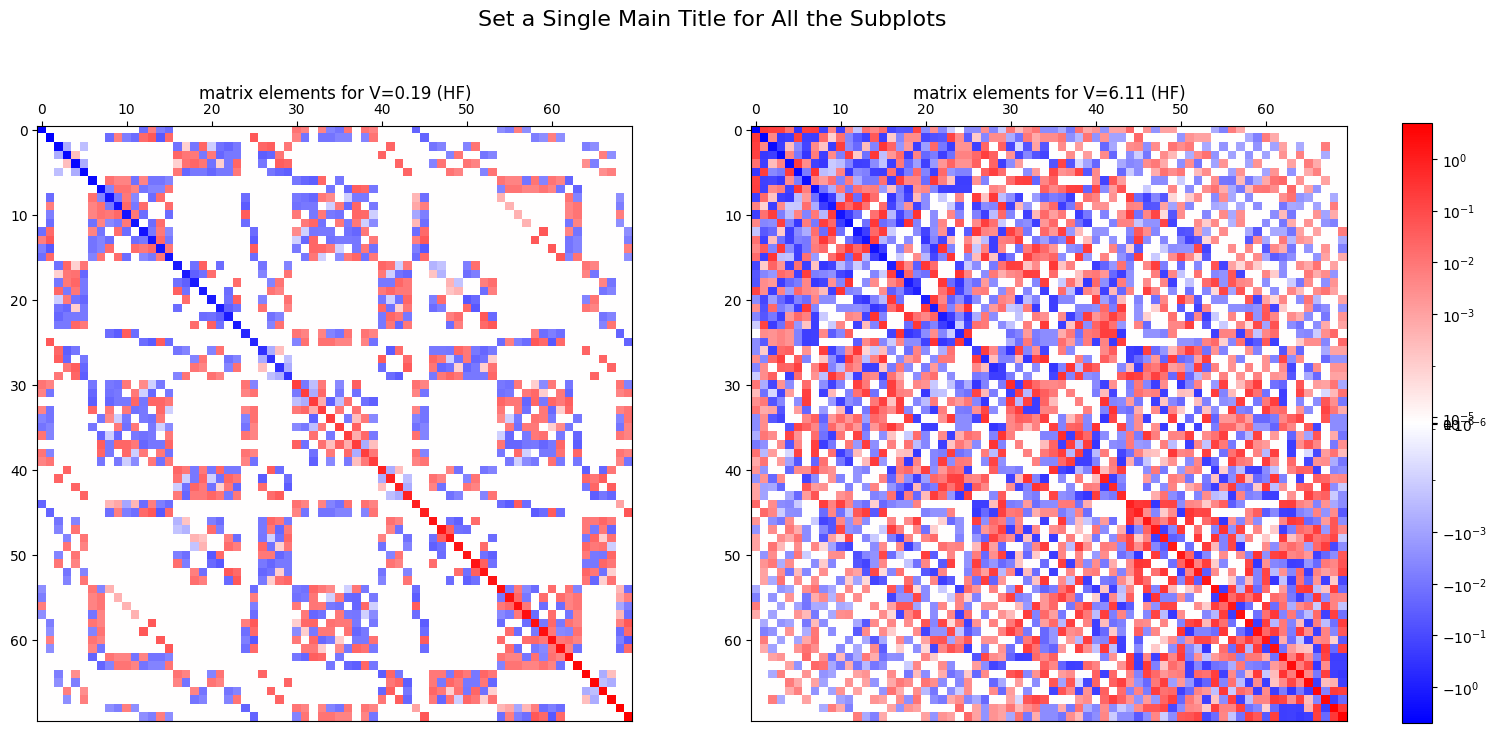

In [90]:
## Ploting matrix elements ##
L = 8
threshod=1.e-6

physical0 = 0.19731, 1.0 
# hf_vwesion0 = free_fermion_superposition(physical, L)
hf_vwesion0 = hart_fock_superposition(physical0, L, max_iters=400, PBC=True, start_point=0.0)
v_fac2 =  np.round(np.max([abs(np.max(hf_vwesion0)), abs(np.min(hf_vwesion0))]), decimals=5)
# print(hf_vwesion0)
print(v_fac2)
physical1 = 0.19731, 1.0 
# hf_vwesion1 = free_fermion_superposition(physical, L)
hf_vwesion1 = hart_fock_superposition(physical1, L, max_iters=400, PBC=False)
v_fac1 =  np.round(np.max([abs(np.max(hf_vwesion1)), abs(np.min(hf_vwesion1))]), decimals=5)
print(v_fac1)
v_fac = np.max([v_fac1,v_fac2])
# print(v_fac)
# print(super_energy2)
# print("")

# mf_energy, super_energy1, vec = mean_field_superposition(physical, L, max_iters=400, basis_len = bs)
# print(super_energy1)
# print("")

# from matplotlib.colors import LogNorm, SymLogNorm

import matplotlib.colors as PL_color

# make a color map of fixed colors
# norm = PL_color.BoundaryNorm(bounds, my_cmap.N)
norm=PL_color.SymLogNorm(linthresh=1.e-5, linscale=1e-1, vmin=-v_fac, vmax=v_fac)



fig, ax = pl.subplots(1,2, figsize=(18, 12) )

# im0 = ax[0].imshow(hf_vwesion0, norm=PL_color.SymLogNorm(linthresh=0.01, vmin=-v_fac, vmax=v_fac))
# hf_vwesion0[ hf_vwesion0 < 1.e-8] = 0.0
# hf_vwesion0 = np.where(np.logical_and( hf_vwesion0 < 1.e-8 , hf_vwesion0 > -1.e-8 ), 0.0, hf_vwesion0)
hf_vwesion0[np.logical_and( hf_vwesion0 < threshod , hf_vwesion0 > -threshod ) ] = 0.0
im0 = ax[0].imshow(hf_vwesion0, norm=norm, cmap='bwr', interpolation='none')
ax[0].set_title(f'matrix elements for V=0.19 (HF)', pad=0)
ax[0].xaxis.tick_top()


# im1 = ax[1].imshow(hf_vwesion1, norm=PL_color.SymLogNorm(linthresh=0.01, vmin=-v_fac, vmax=v_fac))
hf_vwesion1[np.logical_and( hf_vwesion1 < threshod , hf_vwesion1 > -threshod )] = 0.0
im1 = ax[1].imshow(hf_vwesion1, norm=norm, cmap='bwr', interpolation='none')
ax[1].set_title(f'matrix elements for V=6.11 (HF)', pad=0)
ax[1].xaxis.tick_top()

# cb = fig.colorbar(im0, cmap=my_cmap, ax=ax, fraction=0.0215, pad=0.04)#orientation='vertical')
# fig.colorbar(im0, cmap=my_cmap, ax=ax, fraction=0.0215, pad=0.04)#orientation='vertical')
fig.colorbar(im0, ax=ax, fraction=0.0215, pad=0.04, ticks=[-10,-1.0,-0.1,-0.01,-1.e-3,-1.e-6,0,1.e-6,1.e-5,1.e-3,0.01,0.1,1.0,10])#orientation='vertical')
fig.suptitle('Set a Single Main Title for All the Subplots', fontsize=16, y=.84)
# cb.set_clim(-10,10)
pl.show()

[0.2, 0.4, 0.6, 0.8]
HF
HF
HF
HF


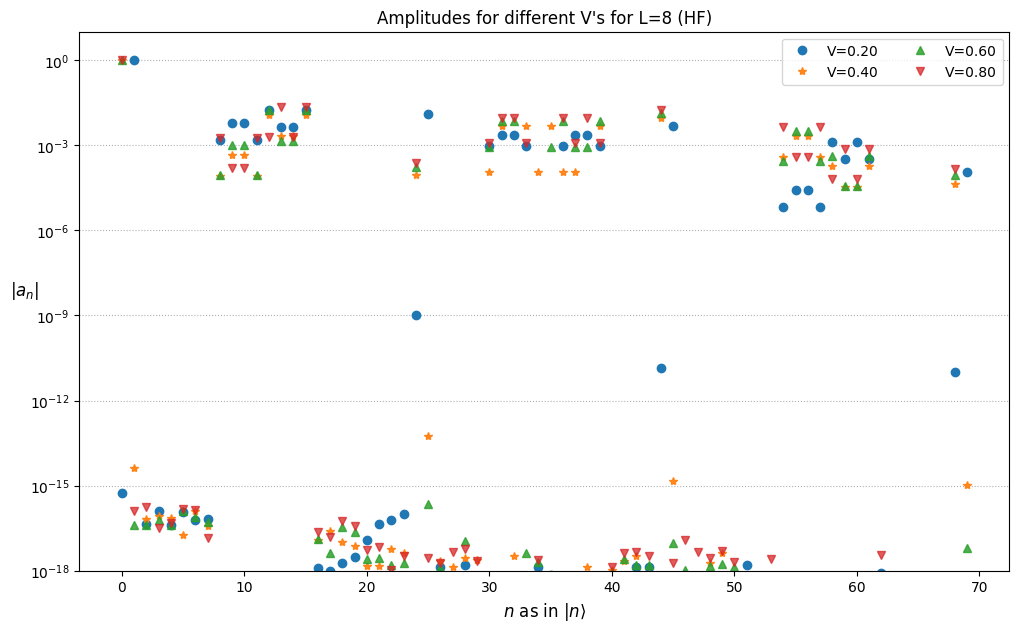

In [17]:
## ploting all the apmlitudes ##
fig = pl.figure(figsize=(12, 7))

L = 8
num_plts = 6
# V_list =  [0.19, 0.79, 1.76, 3.53, 6.44] #np.linspace(0.01, 3.3, num=num_plts, dtype=np.float16)
V_list =  [0.2, 0.4, 0.6, 0.8] #np.linspace(0.01, 3.3, num=num_plts, dtype=np.float16)
print( V_list )

# blues = pl.cm.get_cmap('Blues_r',num_plts+3)
# blues = pl.cm.get_cmap('autumn',num_plts)
marks = ['o','*','^','v','p','s','D','h','8']

for plt, Vs in enumerate(V_list):
    # hf_energy, super_energy, vec = hart_fock_superposition([Vs,1.0], L, max_iters=400)
    sup_ham = hart_fock_superposition([Vs,1.0], L, max_iters=400)
    super_energy, vec = np.linalg.eigh(sup_ham)
    pl.plot(np.abs(vec[:,0]), label=f'V={Vs:.2f}', color=f'C{plt}', marker=marks[plt], linestyle='', linewidth=0.8, alpha=1-(plt*0.5)/num_plts)
    # sup_ham2 = hart_fock_superposition([Vs,1.0], L, PBC=False, max_iters=400)
    # super_energy2, vec2 = np.linalg.eigh(sup_ham2)
    # pl.plot(np.abs(vec2[:,0]), label=f'left V={Vs:.2f}', color=f'C{plt+1}', marker=marks[plt+1], linestyle='', linewidth=0.8, alpha=1-(plt*0.5)/num_plts)


# for plt, Vs in enumerate(V_list):
#     ff_energy, super_energy, vec = free_fermion_superposition([Vs,1.0], L)
#     pl.plot(np.abs(vec), label=f'V={Vs:.2f}', color=f'C{plt}', marker=marks[plt], linestyle='', linewidth=0.8, alpha=1-(plt*0.5)/num_plts)
    

pl.title("Amplitudes for different V's for L=8 (HF)")
pl.xlabel(r"$n$ as in $|n\rangle $", fontsize='large')    
# pl.ylabel(r"$|a_n| $", rotation='horizontal', fontsize='large')    
pl.ylabel(r"$|a_n| $", rotation='horizontal', fontsize='large')    
pl.yscale('log')
pl.ylim(10**-18,10)
pl.legend(loc='best',ncols=2)
pl.grid(which='major', axis='y', linestyle=':')
# pl.savefig("SuperAmps_L12_(FF)(log).pdf", bbox_inches = 'tight')
pl.show()        

[1, 10, 20, 30, 40, 50, 70]
HF
----
HF
HF
----
HF
HF
----
HF
HF
----
HF
HF
----
HF
HF
----
HF
HF
----
HF
[-1.96060551e-16  9.69077172e-01  9.62493607e-17  9.03326841e-16
 -5.79097253e-16 -1.35054541e-16 -3.62619672e-16  1.68585246e-16
  3.58231251e-02  8.28775789e-03  8.28775789e-03 -3.58231251e-02
 -3.22854129e-02  1.39550938e-01  1.39550938e-01  3.22854129e-02
 -1.69999513e-18 -2.39091990e-17 -4.18078522e-17 -3.97374919e-17
  9.45713874e-17  6.57865079e-17  2.32448075e-17 -2.11779413e-17
  6.43033532e-17  1.07665575e-01 -2.43421387e-17  7.27687064e-17
  6.52958641e-17  6.53587563e-17  5.17351469e-04 -1.63224806e-02
  5.17351469e-04  1.63224806e-02 -3.99799551e-18  1.63224806e-02
 -7.07849552e-18  5.17351469e-04 -5.17351469e-04  1.63224806e-02
  2.22512379e-17 -4.24939489e-17  5.26291216e-17 -1.94859930e-17
 -8.68683109e-17 -5.62314587e-02  8.90993957e-18  3.45420036e-18
 -5.19697065e-18  1.81891855e-17 -2.24582316e-17 -8.89045781e-18
 -2.01903008e-17 -2.34777416e-17  1.68756814e-03  

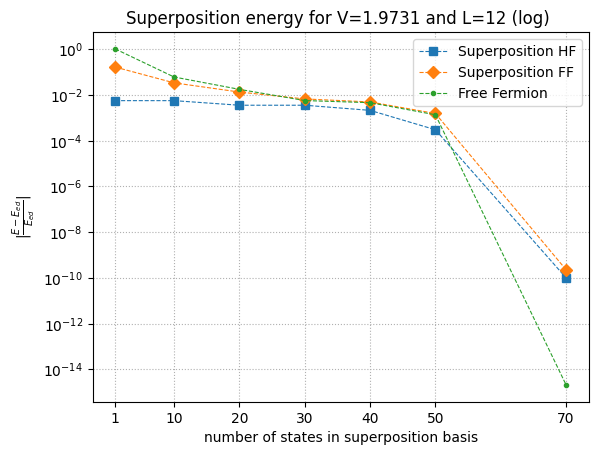

In [ ]:
L = 8
# num_pnts = 10
# pnt_list =  np.linspace(1, 252, num=num_pnts, dtype=np.int32)
# pnt_list =  [1]+[100*x for x in range(1,10)]+[924]
pnt_list =  [1]+[10*x for x in range(1,6)]+[70]
print( pnt_list )
phys = 1.5731, 1.0
ed_energy_PBC = -3.99137284 #-3.61121234 #
ed_energy_OBC = -4.14017799 #-3.61121234 #

hf_fin_state = []

super_data_hf = []
hf_data = []
super_data_mf = []
mf_data = []
super_data_ff = []
ff_data = []
for trunc in pnt_list:
    # hf_energy, super_energy_hf, _ = hart_fock_superposition(phys, L, max_iters=400, PBC=True, basis_len = trunc)
    hf_new_ham = hart_fock_superposition(phys, L, max_iters=400, PBC=True, basis_len = trunc)
    hf_new_E, hf_new_U = np.linalg.eigh(hf_new_ham)
    super_energy_hf = hf_new_E[0]
    # print(super_energy_hf)
    super_data_hf.append(np.abs((ed_energy_PBC - super_energy_hf)/ed_energy_PBC))
    # hf_data.append(np.abs(ed_energy_PBC - super_energy_hf))
    # print(hf_new_U[:,0])
    hf_fin_state = hf_new_U[:,0]
    # print(np.linalg.norm(hf_fin_state))
    # hf_data.append(np.abs(ed_energy_PBC - super_energy_hf))
    
    print("----")
    # mf_energy, super_energy_mf, _ = mean_field_superposition(phys, L, max_iters=200, basis_len = trunc)
    # super_data_mf.append(np.abs(ed_energy - super_energy_mf))
    # mf_data.append(np.abs(ed_energy - mf_energy))

    # ff_energy, super_energy_ff, _ = free_fermion_superposition(phys, L, basis_len = trunc)
    ff_new_ham = hart_fock_superposition(phys, L, PBC=False, basis_len = trunc)
    ff_new_E, ff_new_U = np.linalg.eigh(ff_new_ham)
    super_energy_ff = ff_new_E[0]
    # print(super_energy_ff)
    super_data_ff.append(np.abs((ed_energy_OBC - super_energy_ff)/ed_energy_OBC))
    # ff_data.append(np.abs(ed_energy_OBC - super_energy_ff))

print(hf_fin_state)
hf_fin_state = hf_fin_state**2
print(hf_fin_state)
for numb in pnt_list:
    # hf_fin_data = 1.0-np.cumsum(hf_fin_state[:numb])
    hf_fin_data = 1.0-np.sum(hf_fin_state[:numb])
    print(hf_fin_data)

hf_fin_data = 1.0-np.cumsum(hf_fin_state)
hf_inf = np.array(hf_fin_data)[np.array(pnt_list,dtype=np.int32)-1]
print(hf_inf)
# print(hf_data)
# print(ff_data)

pl.plot(pnt_list, super_data_hf, label=f'HF PBC', ls='--',linewidth=0.8, marker='s')
pl.plot(pnt_list, super_data_hf, label=f'FF PBC', ls=':',linewidth=0.6, marker='s', fillstyle='none')
# pl.plot(pnt_list, super_data_mf, label=f'Superposition MF', ls='--',linewidth=0.8, marker='o')
pl.plot(pnt_list, super_data_ff, label=f'Superposition FF', ls='--',linewidth=0.8, marker='D')
# pl.plot(pnt_list, hf_data, label=f'Hartree-Fock', ls='--',linewidth=0.8, marker='.')
# pl.plot(pnt_list, mf_data, label=f'Mean-Field', ls='--',linewidth=0.8, marker='.')
# pl.plot(pnt_list, ff_data, label=f'Free Fermion', ls='--',linewidth=0.8, marker='.')

pl.plot(pnt_list, hf_inf, label=f'Free Fermion', ls='--',linewidth=0.8, marker='.')

pl.title("Superposition energy for V=1.9731 and L=12 (log) ")
pl.xlabel(r"number of states in superposition basis")    
pl.xticks(pnt_list)
# pl.xscale('log')

pl.ylabel(r"$|\frac{E - E_{ed}}{E_{ed}}| $")    
pl.yscale('log')
pl.grid(which='major', axis='both', linestyle=':')

pl.legend(loc='best')
# pl.savefig("SuperEnrgy_L12_V1.9731_(HF,FF)(log-lin).pdf", bbox_inches = 'tight')
pl.show() 

HF
HF
HF
HF
HF
HF
HF
HF
HF
HF
HF
HF
HF
HF
HF
HF
[1.20331860e-04 1.20317240e-04 4.74430036e-05 4.74422575e-05
 2.20393555e-05 2.33705742e-06 2.62448541e-09 9.99977878e-12]
[6.43962487e-03 6.37194016e-03 3.07952481e-03 3.07948979e-03
 1.77496547e-03 2.32104442e-04 9.49402584e-06 1.00017772e-11]
HF
HF
Ploting coefficients

HF
HF
HF
HF
HF


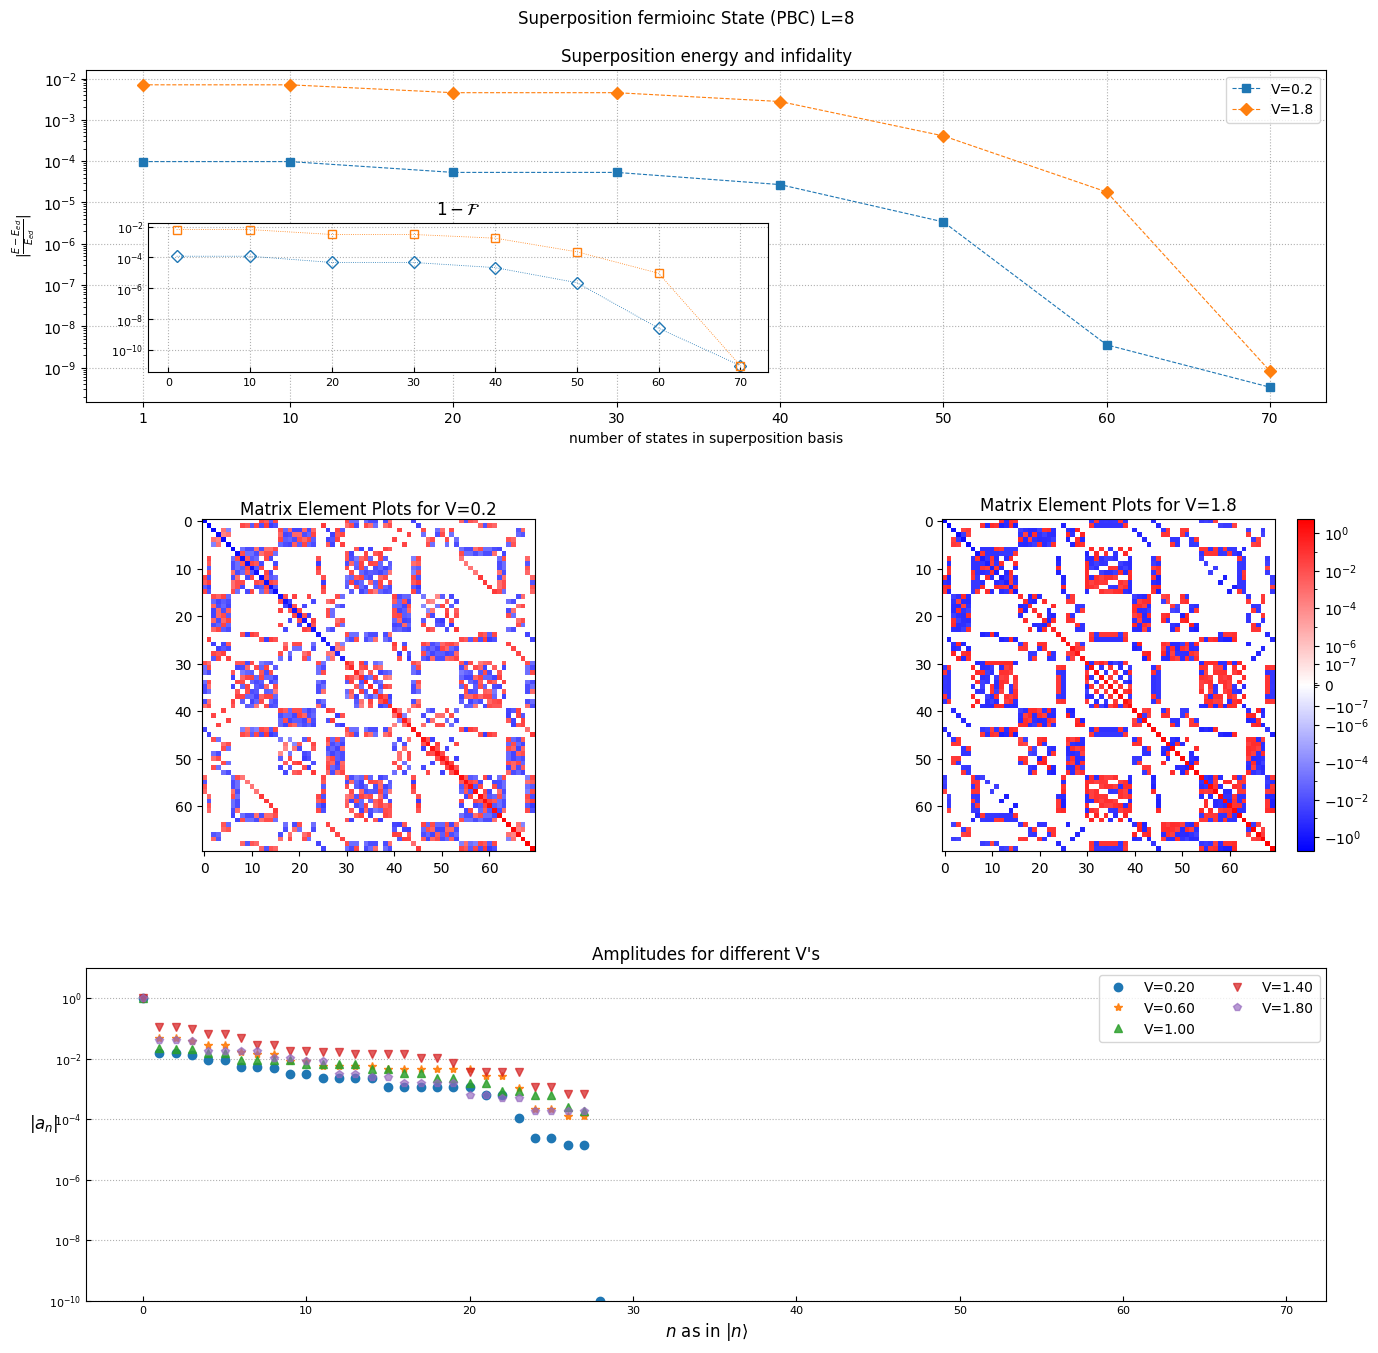

In [172]:
import matplotlib.colors as PL_color

L = 8
threshod=1.e-9

phys0 = 0.20, 1.0
phys1 = 1.80, 1.0

fig = pl.figure(figsize=(16, 20),
                # gridspec_kw={'width_ratios': [3, 3], 'height_ratios': [3, 3], 'wspace' : 0.4, 'hspace' : 0.4}
                )
fig.subplots_adjust(left=None, bottom=None, right=None, top=0.95, wspace=None, hspace=0.35)
fig.suptitle(f"Superposition fermioinc State (PBC) L={L}")

# ax1 = fig.add_subplot(411)
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(423, aspect='equal')
ax3 = fig.add_subplot(424, aspect='equal')
# ax4 = fig.add_subplot(423, aspect='equal')
# ax5 = fig.add_subplot(424, aspect='equal')
ax6 = fig.add_subplot(413)


##################################################################### Ploting superposition energy converg
pnt_list =  [1]+[10*x for x in range(1,7)]+[70]

ed_energy_PBC = -4.71485222
ed_energy_PBC2 = -3.88110981
ed_energy_OBC = -4.67042453
ed_energy_OBC2 = -4.06432307 

lastU_PBC,lastU_OBC =[], []
lastU_PBC2,lastU_OBC2 =[], []
superdata_hf_PBC = []
superdata_hf_PBC2 = []
superdata_hf_OBC = []
superdata_hf_OBC2 = []
for trunc in pnt_list:

    hf_ham_PBC = hart_fock_superposition(phys0, L, max_iters=400, PBC=True, basis_len = trunc)
    PBC_E, PBC_U = np.linalg.eigh(hf_ham_PBC)
    superdata_hf_PBC.append(np.abs((ed_energy_PBC - PBC_E[0])/ed_energy_PBC))
    lastU_PBC = PBC_U[:,0]
    
    hf_ham_PBC2 = hart_fock_superposition(phys1, L, max_iters=400, PBC=True, basis_len = trunc)
    PBC_E2, PBC_U2 = np.linalg.eigh(hf_ham_PBC2)
    superdata_hf_PBC2.append(np.abs((ed_energy_PBC2 - PBC_E2[0])/ed_energy_PBC2))
    lastU_PBC2 = PBC_U2[:,0]
    
    # hf_ham_OBC = hart_fock_superposition(phys0, L, max_iters=400, PBC=False, basis_len = trunc)
    # OBC_E, OBC_U = np.linalg.eigh(hf_ham_OBC)
    # superdata_hf_OBC.append(np.abs((ed_energy_OBC - OBC_E[0])/ed_energy_OBC))
    # lastU_OBC = OBC_U[:,0]

    # hf_ham_OBC2 = hart_fock_superposition(phys1, L, max_iters=400, PBC=False, basis_len = trunc)
    # OBC_E2, OBC_U2 = np.linalg.eigh(hf_ham_OBC2)
    # superdata_hf_OBC2.append(np.abs((ed_energy_OBC2 - OBC_E2[0])/ed_energy_OBC2))
    # lastU_OBC2 = OBC_U2[:,0]


PBC_fin_data = 1.00000000001 - np.cumsum(lastU_PBC**2)
PBC_inf = np.array(PBC_fin_data)[np.array(pnt_list,dtype=np.int64)-1]
print(PBC_inf)
PBC_fin_data2 = 1.00000000001 - np.cumsum(lastU_PBC2**2)
PBC_inf2 = np.array(PBC_fin_data2)[np.array(pnt_list,dtype=np.int64)-1]
print(PBC_inf2)
# OBC_fin_data = 1.00000000001 - np.cumsum(lastU_OBC**2)
# OBC_inf = np.array(OBC_fin_data)[np.array(pnt_list,dtype=np.int64)-1]
# print(OBC_inf)
# OBC_fin_data2 = 1.00000000001 - np.cumsum(lastU_OBC2**2)
# OBC_inf2 = np.array(OBC_fin_data2)[np.array(pnt_list,dtype=np.int64)-1]
# print(OBC_inf2)
    
ax1.plot(pnt_list, superdata_hf_PBC, label=f'V={phys0[0]:.1f}', ls='--',linewidth=0.8, marker='s', color='C0')
ax1.plot(pnt_list, superdata_hf_PBC2, label=f'V={phys1[0]:.1f}', ls='--',linewidth=0.8, marker='D', color='C1')
# ax1.plot(pnt_list, superdata_hf_OBC, label=f'V={phys0[0]}', ls='--',linewidth=0.8, marker='s', color='C0')
# ax1.plot(pnt_list, superdata_hf_OBC2, label=f'V={phys1[0]}', ls='--',linewidth=0.8, marker='D', color='C1')

# ax1.plot(pnt_list, PBC_inf, label=f'infedality PBC', ls=':',linewidth=0.6, marker='D', color='C0', fillstyle='none')
# ax1.plot(pnt_list, OBC_inf, label=f'infedality OBC', ls=':',linewidth=0.6, marker='D', color='C1', fillstyle='none')

ax1.set_title(f"Superposition energy and infidality")
ax1.set_xlabel(r"number of states in superposition basis")    
ax1.set_xticks(pnt_list)
ax1.set_ylabel(r"$|\frac{E - E_{ed}}{E_{ed}}| $")    
ax1.set_yscale('log')
ax1.grid(which='major', axis='both', linestyle=':')
ax1.legend(loc='best')

ins_ax = ax1.inset_axes([0.05,0.09,0.5,0.45])#width="20%", height="20%", loc="lower right", borderpad=1)
ins_ax.set_yscale('log')
ins_ax.grid(which='major', axis='both', linestyle=':')
ins_ax.tick_params(direction='in', labelsize=8)
ins_ax.set_title(r"$1-\mathcal{F}$")
ins_ax.plot(pnt_list, PBC_inf, label=f'V={phys0[0]:.1f}', ls=':',linewidth=0.6, marker='D', color='C0', fillstyle='none')
ins_ax.plot(pnt_list, PBC_inf2, label=f'V={phys1[0]:.1f}', ls=':',linewidth=0.6, marker='s', color='C1', fillstyle='none')
# ins_ax.plot(pnt_list, OBC_inf, label=f'V={phys0[0]:.1f}', ls=':',linewidth=0.6, marker='s', color='C0', fillstyle='none')
# ins_ax.plot(pnt_list, OBC_inf2, label=f'V={phys0[0]:.1f}', ls=':',linewidth=0.6, marker='D', color='C1', fillstyle='none')

##################################################################### Ploting matrix elements PBC


hf_vwesion0 = hart_fock_superposition(phys0, L, max_iters=400, PBC=True)
v_fac2 =  np.round(np.max([abs(np.max(hf_vwesion0)), abs(np.min(hf_vwesion0))]), decimals=5)
hf_vwesion0[np.logical_and( hf_vwesion0 < threshod , hf_vwesion0 > -threshod ) ] = 0.0

hf_vwesion1 = hart_fock_superposition(phys1, L, max_iters=400, PBC=True)
v_fac1 =  np.round(np.max([abs(np.max(hf_vwesion1)), abs(np.min(hf_vwesion1))]), decimals=5)
hf_vwesion1[np.logical_and( hf_vwesion1 < threshod , hf_vwesion1 > -threshod ) ] = 0.0

v_fac = np.max([v_fac1,v_fac2])
norm=PL_color.SymLogNorm(linthresh=1.e-8, linscale=1e-1, vmin=-v_fac, vmax=v_fac)

im0 = ax2.imshow(hf_vwesion0, norm=norm, cmap='bwr', interpolation='none', aspect='equal')
ax2.set_title(f"Matrix Element Plots for V=0.2", pad=0.20)
# ax2.xaxis.tick_top()

im1 = ax3.imshow(hf_vwesion1, norm=norm, cmap='bwr', interpolation='none', aspect='equal')
ax3.set_title(f"Matrix Element Plots for V=1.8")
# ax3.xaxis.tick_top()
fig.colorbar(im0, ax=ax3, fraction=0.0515, pad=0.04, ticks=[-1e+1,-1.e+0,-1.e-2,-1.e-4,-1.e-6,-1.e-7,0,1.e-7,1.e-6,1.e-4,1.e-2,1.e+0,1.e+1,])#orientation='vertical')
# fig.suptitle('Set a Single Main Title for All the Subplots', fontsize=16, y=.84)


################################################################### Ploting matrix elements OBC
# hf_vwesion0obc = hart_fock_superposition(physical0, L, max_iters=400, PBC=False)
# v_fac2 =  np.round(np.max([abs(np.max(hf_vwesion0)), abs(np.min(hf_vwesion0))]), decimals=5)

# hf_vwesion1obc = hart_fock_superposition(physical1, L, max_iters=400, PBC=False)
# v_fac1 =  np.round(np.max([abs(np.max(hf_vwesion1)), abs(np.min(hf_vwesion1))]), decimals=5)
# v_fac = np.max([v_fac1,v_fac2])

# norm=PL_color.SymLogNorm(linthresh=1.e-8, linscale=1e-1, vmin=-v_fac, vmax=v_fac)

# im0 = ax4.imshow(hf_vwesion0obc, norm=norm, cmap='bwr', interpolation='none', aspect='auto')
# ax4.set_title(f"Matrix Element Plots for V=0.2")
# # ax2.set_title(f'matrix elements for V=0.19 (HF)', pad=0)
# ax4.xaxis.tick_top()

# im1 = ax5.imshow(hf_vwesion1obc, norm=norm, cmap='bwr', interpolation='none', aspect='auto')
# ax5.set_title(f"Matrix Element Plots for V=1.8")
# ax5.xaxis.tick_top()

# fig.colorbar(im0, ax=ax5, fraction=0.0515, pad=0.04, ticks=[-1e+1,-1.e+0,-1.e-2,-1.e-4,-1.e-6,-1.e-7,0,1.e-7,1.e-6,1.e-4,1.e-2,1.e+0,1.e+1])#orientation='vertical')
# # fig.suptitle('Set a Single Main Title for All the Subplots', fontsize=16, y=.84)


################################################################### Ploting coefficients
print('Ploting coefficients')
print("")
V_list =  [0.2, 0.6, 1.0, 1.4, 1.8] #np.linspace(0.01, 3.3, num=num_plts, dtype=np.float16)

marks = ['o','*','^','v','p','s','D','h','8']

for plt, Vs in enumerate(V_list):
    # hf_energy, super_energy, vec = hart_fock_superposition([Vs,1.0], L, max_iters=400)
    sup_ham = hart_fock_superposition([Vs,1.0], L, PBC=True, max_iters=400)
    super_energy, vec = np.linalg.eigh(sup_ham)
    # ax6.plot(np.abs(vec[:,0]), label=f'V={Vs:.2f}', color=f'C{plt}', marker=marks[plt], linestyle='', linewidth=0.8, alpha=1-(plt*0.5)/num_plts)
    
    ax6.plot(np.sort(np.abs(vec[:,0]))[::-1], label=f'V={Vs:.2f}', color=f'C{plt}', marker=marks[plt], linestyle='', linewidth=0.8, alpha=1-(plt*0.5)/num_plts)
    # sup_ham2 = hart_fock_superposition([Vs,1.0], L, PBC=False, max_iters=400)
    # super_energy2, vec2 = np.linalg.eigh(sup_ham2)
    # pl.plot(np.abs(vec2[:,0]), label=f'left V={Vs:.2f}', color=f'C{plt+1}', marker=marks[plt+1], linestyle='', linewidth=0.8, alpha=1-(plt*0.5)/num_plts)


# for plt, Vs in enumerate(V_list):
#     ff_energy, super_energy, vec = free_fermion_superposition([Vs,1.0], L)
#     pl.plot(np.abs(vec), label=f'V={Vs:.2f}', color=f'C{plt}', marker=marks[plt], linestyle='', linewidth=0.8, alpha=1-(plt*0.5)/num_plts)
    

ax6.set_title(f"Amplitudes for different V's")
ax6.set_xlabel(r"$n$ as in $|n\rangle $", fontsize='large')    
# pl.ylabel(r"$|a_n| $", rotation='horizontal', fontsize='large')    
ax6.set_ylabel(r"$|a_n| $", rotation='horizontal', fontsize='large')
ax6.tick_params(direction='in', labelsize=8)    
ax6.set_yscale('log')
ax6.set_ylim(10**-10,10)
ax6.legend(loc='best',ncols=2)
ax6.grid(which='major', axis='y', linestyle=':')


pl.savefig("SuperPos_L8_(HF)(PBC)(sorted).pdf", bbox_inches = 'tight')
pl.show()




In [98]:
L = 6
physical = 1.330, 1.0    
max_iters =  100
startp = 0.51

c_mat = np.diag([1.,0.]*(L//2) + startp * np.random.randn(L))
# c_mat = np.diag( startp * np.random.randn(L))

last_H = np.empty((L,L))
last_E = np.empty((L))
last_U = np.empty((L,L))
hf_energy = np.zeros(max_iters)
for in_dx in range(max_iters):
    H = HF_hamil(physical, c_mat, L)
    last_E,last_U = np.linalg.eigh(H)
    c_mat = np.dot(last_U[:,:L//2],np.conj(last_U[:,:L//2].T))
    hf_energy[in_dx] = fullEnergy_HF(c_mat, physical, L)
    last_H = H
print("--- end of HF ---")
# print(np.round(last_H, decimals=6))
# print(np.round(last_E, decimals=6))

        
my_set = ordered_basis(L,last_E, lent=None)
print(my_set, len(my_set))
V, J = physical
el = len(my_set)
cntr=0
new_ham = np.zeros((el,el))
# for indx_k in range(el):
    # K = my_set[indx_k]
for indx_k, K in enumerate(my_set):
    K_state = np.array([int(i) for i in np.binary_repr(K, width=L)])
    K_set = np.nonzero([int(i) for i in np.binary_repr(K, width=L)])[0]
    # for indx_q in range(indx_k,el):
        # Q = my_set[indx_q]
    for indx_q, Q in enumerate(my_set):
        Q_state = np.array([int(i) for i in np.binary_repr(Q, width=L)])
        Q_set = np.nonzero([int(i) for i in np.binary_repr(Q, width=L)])[0]

        cntr += 1
        N = K ^ Q
        N_state = np.array([int(i) for i in np.binary_repr(N, width=L)])
        N_set = np.nonzero(N_state)[0]

        # print("(",K_set,",",Q_set,") == ",  np.round(V_term(last_U, K,Q), decimals=6),",",np.round(V_test(last_U, K,Q), decimals=6) )
        # print("(",K_set,",",Q_set,") == ",  np.round(C_term(last_U, K,Q), decimals=6),",",np.round(C_test(last_U, K,Q), decimals=6) )
        
        if np.round(C_term(last_U, K,Q,L), decimals=6) != np.round(C_test(last_U, K,Q, L), decimals=6):
            print("(",K_set,",",Q_set,") == ",  np.round(C_term(last_U, K,Q), decimals=6),",",np.round(C_test(last_U, K,Q), decimals=6) )
        
        if np.round(V_term(last_U, K,Q, L), decimals=8) != np.round(V_test(last_U, K,Q, L), decimals=8):
            print("(",K_set,",",Q_set,") == ",  np.round(V_term(last_U, K,Q), decimals=6),",",np.round(V_test(last_U, K,Q), decimals=6) )
        
        
# print(output_energy[-1])
print(cntr)
# print(np.round(new_ham, decimals=5))
# print(np.round(based_ham( [V,J], L, last_E, last_U), decimals=5))

# te =np.linalg.eigvalsh(new_ham)
# print(te)

--- end of HF ---
[56 52 50 44 42 28 49 26 41 38 25 22 37 14 35 19 13 21 11  7] 20
400


# 2D case: #

-0.0057493669506091735
-0.5740424109434589
-1.128132456714385
-1.6663093648234857
-2.1866574558227962
-2.6870487705152963
-3.165147377127605
-3.6184307273051166
-4.044235312325158
-4.439834265850548
-4.802553109902924
-5.1299253773699665
-5.4198815606337725
-5.670953247560038
-5.882462245020606
-6.0546571581284905
-6.188762923382091
-6.28692453976872
-6.352050748990065
-6.387587285998412
-6.397262908418669
-6.384850560424011
-6.35397375016164
-6.307971606105043
-6.249821659143005
-6.1821104568475835
-6.107038726702982
-6.02644830999023
-5.941860549075608
-5.854518775107387


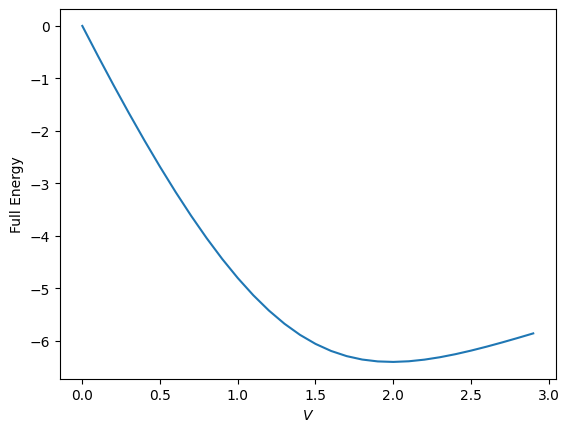

In [9]:
def hamil_2d(V, n, dims):
    Lx, Ly = dims
    
    H_X = np.eye(Lx, k=1) + np.eye(Lx, k=-1)  + np.eye(Lx, k=Lx-1)  + np.eye(Lx, k=-Lx+1)    
    if Ly==2:
        H_Y = np.eye(Ly, k=1) + np.eye(Ly, k=-1)
    else:
        H_Y = np.eye(Ly, k=1) + np.eye(Ly, k=-1)  + np.eye(Ly, k=Ly-1)  + np.eye(Ly, k=-Ly+1)
    H_mat = -1 * np.kron(H_Y, np.eye(Lx)) + np.kron(np.eye(Ly), H_X)

    for x in range(Lx):
        for y in range(Lx):
            org = x+Lx*y
            l,r = np.mod(x+1,Lx)+Lx*np.mod(y  ,Ly), np.mod(x-1,Lx)+Lx*np.mod(y  ,Ly)
            u,d = np.mod(x  ,Lx)+Lx*np.mod(y-1,Ly), np.mod(x  ,Lx)+Lx*np.mod(y+1,Ly)
            H_mat[org,org] = -V/2*( n[l] + n[r] + n[u] + n[d] )
        
    return(H_mat)


def mean_field_2d(V, n, dims):
    Lx,Ly = dims
    L = Lx*Ly
    # energy_list = []
    for i in range(200):
        H = hamil_2d(V,n, (Lx,Ly))
        E,U = np.linalg.eigh(H)
        
        C = np.dot(U[:,:L//2],np.conj(U[:,:L//2].T))
        n = np.diag(C)
        # energy_list.append(fullenergy_2d(C, (Lx,Ly)))
    return n, C #, energy_list



def fullenergy_2d(C, dims):
    
    Lx, Ly = dims
    
    ad_X = np.eye(Lx, k=1) + np.eye(Lx, k=-1)  + np.eye(Lx, k=Lx-1)  + np.eye(Lx, k=-Lx+1)    
    
    if Ly==2:
        ad_Y = np.eye(Ly, k=1) + np.eye(Ly, k=-1)
    else:
        ad_Y = np.eye(Ly, k=1) + np.eye(Ly, k=-1)  + np.eye(Ly, k=Ly-1)  + np.eye(Ly, k=-Ly+1)

    ad_mat = np.kron(ad_Y, np.eye(Lx)) + np.kron(np.eye(Ly), ad_X)
    
    E = 0.0    
    for xx in range(Lx*Ly):
        for yy in range(Lx*Ly):
            E += - 1.0 * ad_mat[xx,yy] * C[xx,yy]
            E += + V/2*ad_mat[xx,yy] * C[xx,yy] * C[yy,xx]
            E += - V/2*ad_mat[xx,yy] * C[xx,xx] * C[yy,yy]
    
    return E


Lx, Ly = 4, 4
n = [1.,0.]*( (Lx*Ly)//2 )
n += np.random.randn( Lx*Ly )
Vs = np.arange(0.001,3,0.1)

ns = []
energy = []
for V in Vs:
    # density, CMAT, energy_list = mean_field_2d(V, n, (Lx,Ly) )
    density, CMAT = mean_field_2d(V, n, (Lx,Ly) )
    ns.append( sum(density[:]) )
    energy.append( fullenergy_2d(CMAT, (Lx, Ly) ) )
    print(fullenergy_2d( CMAT, (Lx,Ly) ))
    # print(V)
    # pl.plot(energy_list)
    # pl.show()



# pl.plot(energy_list)
# pl.ylabel("Energy")
# pl.xlabel("$V$")
# pl.show()

pl.plot(Vs, energy)
pl.ylabel("Full Energy")
pl.xlabel("$V$")
pl.show()

# ns = np.array(ns).T

# pl.plot(Vs,ns,".")
# # pl.plot(Vs,ns[0,:],".")
# # pl.plot(Vs,ns[1,:],".")
# pl.ylabel("$n$")
# pl.xlabel("$V$")
# pl.show()



In [59]:
Lx,Ly = 4, 4
CMAT = np.random.random((Lx*Ly,Lx*Ly))
CMAT = 0.5* ( CMAT+np.transpose(CMAT) )
ss = fullenergy_2d(CMAT,(Lx,Ly))
print(ss)

C  (16, 16)
ad  (16, 16)
E0 ()  ->  0.0
E2 ()  ->  0.0
E2 ()  ->  0.718974463830807
E2 ()  ->  0.718974463830807
E2 ()  ->  1.0
E2 ()  ->  0.5756110656739178
E2 ()  ->  0.5756110656739178
E2 ()  ->  0.0
E2 ()  ->  0.5044239823176409
E2 ()  ->  0.5044239823176409
E2 ()  ->  1.0
E2 ()  ->  0.29631941502243486
E2 ()  ->  0.29631941502243486
E2 ()  ->  1.0
E2 ()  ->  0.26769244778617735
E2 ()  ->  0.26769244778617735
E2 ()  ->  0.0
E2 ()  ->  0.565177603607301
E2 ()  ->  0.565177603607301
E2 ()  ->  0.0
E2 ()  ->  0.2454594678768275
E2 ()  ->  0.2454594678768275
E2 ()  ->  0.0
E2 ()  ->  0.06647953665483552
E2 ()  ->  0.06647953665483552
E2 ()  ->  0.0
E2 ()  ->  0.18109390449538354
E2 ()  ->  0.18109390449538354
E2 ()  ->  0.0
E2 ()  ->  0.7406210472854267
E2 ()  ->  0.7406210472854267
E2 ()  ->  0.0
E2 ()  ->  0.40974963869772923
E2 ()  ->  0.40974963869772923
E2 ()  ->  0.0
E2 ()  ->  0.20818761642428657
E2 ()  ->  0.20818761642428657
E2 ()  ->  1.0
E2 ()  ->  0.2024047259489103
E2 ()  